## Facial keypoints detection

In this task you will create facial keypoint detector based on CNN regressor.


![title](example.png)

### Load and preprocess data

Script `get_data.py` unpacks data — images and labelled points. 6000 images are located in `images` folder and keypoint coordinates are in `gt.csv` file. Run the cell below to unpack data.

!pip install get_data

In [6]:
from get_data import unpack
unpack('facial-keypoints-data.zip')

ModuleNotFoundError: No module named 'get_data'

Now you have to read `gt.csv` file and images from `images` dir. File `gt.csv` contains header and ground truth points for every image in `images` folder. It has 29 columns. First column is a filename and next 28 columns are `x` and `y` coordinates for 14 facepoints. We will make following preprocessing:
1. Scale all images to resolution $100 \times 100$ pixels.
2. Scale all coordinates to range $[-0.5; 0.5]$. To obtain that, divide all x's by width (or number of columns) of image, and divide all y's by height (or number of rows) of image and subtract 0.5 from all values.

Function `load_imgs_and_keypoint` should return a tuple of two numpy arrays: `imgs` of shape `(N, 100, 100, 3)`, where `N` is the number of images and `points` of shape `(N, 28)`.

In [30]:
### Useful routines for preparing data
import numpy as np
from numpy import array, zeros
from os.path import join
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize
import csv, cv2
import os
import skimage

In [32]:
img_size = 100
num_imgs = 3000


def load_imgs_and_keypoints(dirname='facial-keypoints'):
    point_dict = {}
    with open("./data/gt.csv", "r") as csvfile:
        csvreader = csv.reader(csvfile)
        count =0
        for row in csvreader:
            if count ==0:
                count+=1
                continue
            point_dict[row[0]]=[int(x) for x in row[1:]]
    print("dictin")
    
    folder = "./data/images"
    images= []
    points=[]
    for filename in sorted(os.listdir(folder))[num_imgs:2*num_imgs]:
        img = cv2.cvtColor(cv2.imread(os.path.join(folder,filename)), cv2.COLOR_BGR2RGB)
        cols,rows,_ = img.shape
        if img is not None:
            images.append(skimage.transform.resize(img,(img_size,img_size)))
            point = point_dict[filename]
            #print(point, img.shape)
            for i in range(14):
                point[2*i] = point[2*i]/cols - 0.5
                point[2*i+1] = point[2*i+1]/rows - 0.5
            #print(point)
            points.append(point)
      
    images = np.array(images)
    points = np.array(points)
   
    print(images.shape,points.shape)
    
    return images, points
    
    # Write your code for loading images and points here


imgs, points = load_imgs_and_keypoints()

dictin
(3000, 100, 100, 3) (3000, 28)


array([-0.21264368, -0.36206897, -0.00574713, -0.3045977 ,  0.17816092,
       -0.23563218,  0.35057471, -0.23563218, -0.20114943, -0.23563218,
       -0.12068966, -0.23563218, -0.04022989, -0.22413793,  0.14367816,
       -0.14367816,  0.22413793, -0.16666667,  0.31609195, -0.12068966,
        0.01724138,  0.06321839, -0.20114943,  0.16666667, -0.01724138,
        0.21264368,  0.14367816,  0.20114943])

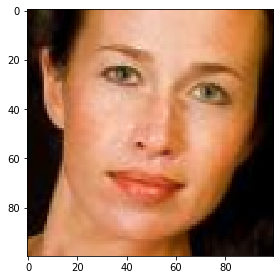

In [33]:
# Example of output
%matplotlib inline
from skimage.io import imshow
imshow(imgs[0])
points[0]

### Visualize data

Let's prepare a function to visualize points on image. Such function obtains two arguments: an image and a vector of points' coordinates and draws points on image (just like first image in this notebook).

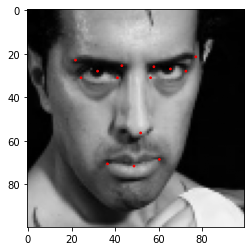

In [34]:
import matplotlib.pyplot as plt
# Circle may be useful for drawing points on face
# See matplotlib documentation for more info
from matplotlib.patches import Circle

def visualize_points(img, points):
    plt.figure()
    plt.imshow(img)
    cols, rows, _ = img.shape
    patches =[]
    r=0.4
    fig = plt.gcf()
    ax= fig.gca()
    for i in range(14):
        ax.add_artist((Circle(((points[2*i]+0.5)*cols, (points[2*i+1]+0.5)*
                                                        rows), r, color = 'r')))
    
    # Write here function which obtains image and normalized
    # coordinates and visualizes points on image
    pass
    
visualize_points(imgs[1], points[1])

In [35]:
def visualize_points1(img, points,j):
    plt.figure()
    plt.imshow(img)
    cols,rows,_ = img.shape
    patches=[]
    r=0.4
    fig = plt.gcf()
    ax = fig.gca()
    for i in range(j,j+1):
        ax.add_artist((Circle(((points[2*i]+0.5)*cols, (points[2*i+1]+0.5)*rows), r, color='r')))

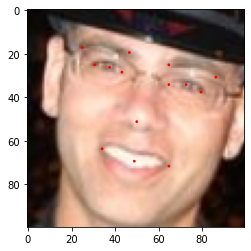

In [41]:
visualize_points(imgs[2], points[2])

### Train/val split

Run the following code to obtain train/validation split for training neural network.

In [42]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points, test_size=0.1)

In [60]:
imgs.shape

(3000, 100, 100, 3)

### Simple data augmentation

For better training we will use simple data augmentation — flipping an image and points. Implement function flip_img which flips an image and its' points. Make sure that points are flipped correctly! For instance, points on right eye now should be points on left eye (i.e. you have to mirror coordinates and swap corresponding points on the left and right sides of the face). VIsualize an example of original and flipped image.

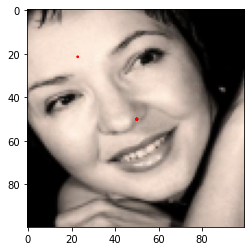

In [64]:
def flip_img(img, points):
    # Write your code for flipping here
    img_flip = img[:, ::-1]
    points_flip = np.zeros(points.shape)
    flip_indices = [3, 2, 1, 0, 9, 8, 7, 6, 5, 4, 10, 13, 12, 11]
    for i in range(14):
        points_flip[2*i] = -points[2*flip_indices[i]]
        points_flip[2*i+1] = points[2*flip_indices[i]+1]
        return img_flip, points_flip

f_img, f_points = flip_img(imgs[6], points[1])
visualize_points(f_img, f_points)

Time to augment our training sample. Apply flip to every image in training sample. As a result you should obtain two arrays: `aug_imgs_train` and `aug_points_train` which contain original images and points along with flipped ones.

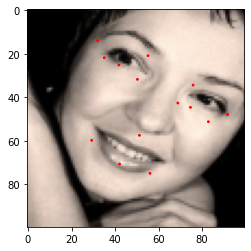

In [65]:
visualize_points(imgs[6], points[6])

In [74]:
aug_imgs_train= []
aug_points_train = []

for i in range(imgs_train.shape[0]):
    img_flip , points_flip = flip_img(imgs_train[i], points_train[i])
    aug_imgs_train.append(imgs_train[i])
    aug_imgs_train.append(img_flip)
    aug_points_train.append(points_train[i])
    aug_points_train.append(points_flip)
aug_imgs_train = np.array(aug_imgs_train)
aug_points_train = np.array(aug_points_train)
print(imgs_train.shape, points_train.shape)
print(aug_imgs_train.shape, aug_points_train.shape)
    

(2700, 100, 100, 3) (2700, 28)
(5400, 100, 100, 3) (5400, 28)


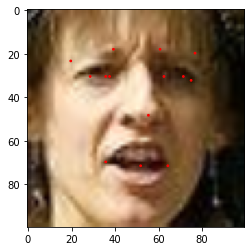

In [80]:
visualize_points(aug_imgs_train[6], aug_points_train[6])

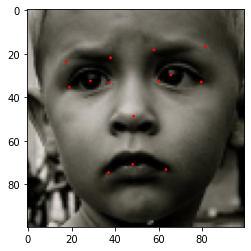

In [82]:
visualize_points(aug_imgs_train[4], aug_points_train[4])

### Network architecture and training

Now let's define neural network regressor. It will have 28 outputs, 2 numbers per point. The precise architecture is up to you. We recommend to add 2-3 (`Conv2D` + `MaxPooling2D`) pairs, then `Flatten` and 2-3 `Dense` layers. Don't forget about ReLU activations. We also recommend to add `Dropout` to every `Dense` layer (with p from 0.2 to 0.5) to prevent overfitting.


In [87]:
!pip install keras
!pip install tensorflow

     |████████████████████████████████| 454.4 MB 58 kB/s  eta 0:00:01188 kB/s eta 0:22:55
  Using cached tensorboard-2.5.0-py3-none-any.whl (6.0 MB)
  Using cached termcolor-1.1.0.tar.gz (3.9 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
     |████████████████████████████████| 14.9 MB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 4.0 MB 790 kB/s eta 0:00:01
  Using cached tensorflow_estimator-2.5.0-py2.py3-none-any.whl (462 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached keras_nightly-2.5.0.dev2021032900-py2.py3-none-any.whl (1.2 MB)
     |████████████████████████████████| 1.0 MB 2.1 MB/s eta 0:00:01
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
     |████████████████████████████████| 4.4 MB 2.2 MB/s eta 0:00:01
  Using cached absl_py-0.12.0-py3-none-any.whl (129 kB)
  Using cached google_p

In [90]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.initializers import glorot_uniform


model = Sequential()

model.add(Conv2D(16, (3,3), input_shape=(img_size, img_size, 3), padding="same",kernel_initializer=glorot_uniform()))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3,3), padding="same",kernel_initializer=glorot_uniform()))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), padding="same",kernel_initializer=glorot_uniform()))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))  

model.add(Flatten())
model.add(Dense(128,kernel_initializer=glorot_uniform()))
model.add(LeakyReLU(alpha=0.1))

model.add(Dropout(0.5)) 

model.add(Dense(64,kernel_initializer=glorot_uniform()))
model.add(LeakyReLU(alpha=0))

model.add(Dense(28,kernel_initializer=glorot_uniform()))


In [91]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 100, 100, 16)      448       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 100, 100, 16)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 50, 50, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 25, 25, 32)       

Time to train! Since we are training a regressor, make sure that you use mean squared error (mse) as loss. Feel free to experiment with optimization method (SGD, Adam, etc.) and its' parameters.

In [103]:
# ModelCheckpoint can be used for saving model during training.
# Saved models are useful for finetuning your model 
# See keras documentation for more info
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam

# Choose optimizer, compile model and run training
model.compile(loss="mean_squared_error", optimizer = Adam(), metrics = ['accuracy'])

In [111]:
BATCH_SIZE= 32
EPOCHS= 100
model.load_weights('my_model_weights.h5')

In [112]:
hist = model.fit(
    aug_imgs_train, aug_points_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(imgs_val, points_val),
    shuffle=True,
    verbose=1
)

Epoch 1/100
169/169 [==============================] - 12s 73ms/step - loss: 0.0097 - accuracy: 0.4178 - val_loss: 0.0102 - val_accuracy: 0.8600
Epoch 2/100
169/169 [==============================] - 14s 83ms/step - loss: 0.0096 - accuracy: 0.4135 - val_loss: 0.0111 - val_accuracy: 0.8600
Epoch 3/100
169/169 [==============================] - 15s 88ms/step - loss: 0.0095 - accuracy: 0.4133 - val_loss: 0.0100 - val_accuracy: 0.8600
Epoch 4/100
169/169 [==============================] - 15s 89ms/step - loss: 0.0093 - accuracy: 0.4035 - val_loss: 0.0100 - val_accuracy: 0.8633
Epoch 5/100
169/169 [==============================] - 15s 86ms/step - loss: 0.0093 - accuracy: 0.4117 - val_loss: 0.0094 - val_accuracy: 0.8600
Epoch 6/100
169/169 [==============================] - 14s 83ms/step - loss: 0.0091 - accuracy: 0.4111 - val_loss: 0.0096 - val_accuracy: 0.8700
Epoch 7/100
169/169 [==============================] - 14s 82ms/step - loss: 0.0090 - accuracy: 0.4015 - val_loss: 0.0087 - val_ac

169/169 [==============================] - 14s 80ms/step - loss: 0.0022 - accuracy: 0.4337 - val_loss: 0.0128 - val_accuracy: 0.8367
Epoch 58/100
169/169 [==============================] - 13s 77ms/step - loss: 0.0023 - accuracy: 0.4291 - val_loss: 0.0108 - val_accuracy: 0.8167
Epoch 59/100
169/169 [==============================] - 13s 75ms/step - loss: 0.0023 - accuracy: 0.4307 - val_loss: 0.0133 - val_accuracy: 0.8200
Epoch 60/100
169/169 [==============================] - 13s 78ms/step - loss: 0.0022 - accuracy: 0.4339 - val_loss: 0.0112 - val_accuracy: 0.8200
Epoch 61/100
169/169 [==============================] - 13s 76ms/step - loss: 0.0023 - accuracy: 0.4311 - val_loss: 0.0130 - val_accuracy: 0.8033
Epoch 62/100
169/169 [==============================] - 13s 79ms/step - loss: 0.0023 - accuracy: 0.4328 - val_loss: 0.0132 - val_accuracy: 0.8200
Epoch 63/100
169/169 [==============================] - 13s 79ms/step - loss: 0.0022 - accuracy: 0.4307 - val_loss: 0.0136 - val_accuracy

In [110]:
train_acc=hist.history['accuracy']
train_acc

[0.41870370507240295,
 0.4077777862548828,
 0.41203704476356506,
 0.4027777910232544,
 0.4031481444835663,
 0.40481480956077576,
 0.39666667580604553,
 0.3992592692375183,
 0.4033333361148834,
 0.40388888120651245,
 0.4031481444835663,
 0.4046296179294586,
 0.4075925946235657,
 0.41148146986961365,
 0.41296297311782837,
 0.41555556654930115,
 0.4157407283782959,
 0.4183333218097687,
 0.41907408833503723,
 0.4157407283782959,
 0.4207407534122467,
 0.42092591524124146,
 0.42314815521240234,
 0.4211111068725586,
 0.42314815521240234,
 0.4225925803184509,
 0.4287036955356598,
 0.4264814853668213,
 0.4277777671813965,
 0.4268518388271332,
 0.42759260535240173,
 0.42907407879829407,
 0.4268518388271332,
 0.42759260535240173,
 0.42444443702697754,
 0.42814815044403076,
 0.4251851737499237,
 0.4305555522441864,
 0.43129628896713257,
 0.43481481075286865,
 0.43296295404434204,
 0.43037036061286926,
 0.431851863861084,
 0.4287036955356598,
 0.42907407879829407,
 0.43203702569007874,
 0.430370360

In [97]:
model.save_weights('my_model_weights.h5')

### Visualize results

Now visualize neural network results on several images from validation sample. Make sure that your network outputs different points for images (i.e. it doesn't output some constant).

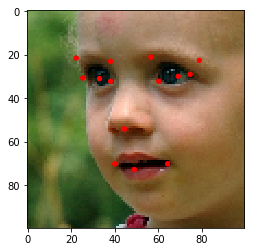

In [20]:
val_points_pred = model.predict(imgs_val)

In [ ]:
print(val_points_pred.shape)

In [ ]:
for i in range(11,15):
    visualize_points(imgs_val[i], val_points_pred[i])